# Data Prep

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('whitegrid')
idx = pd.IndexSlice
deciles = np.arange(.1, 1, .1).round(1)

## Load Data

In [4]:
DATA_STORE = Path('..', 'data', 'assets.h5')

In [5]:
with pd.HDFStore(DATA_STORE) as store:
    data = (store['quandl/wiki/prices']
            .loc[idx['2007':'2016', :],
                 ['adj_open', 'adj_high', 'adj_low', 'adj_close', 'adj_volume']]
            .dropna()
            .swaplevel()
            .sort_index()
            .rename(columns=lambda x: x.replace('adj_', '')))
    metadata = store['us_equities/stocks'].loc[:, ['marketcap', 'sector']]

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6951874 entries, ('A', Timestamp('2007-01-03 00:00:00')) to ('ZUMZ', Timestamp('2016-12-30 00:00:00'))
Data columns (total 5 columns):
 #   Column  Dtype  
---  ------  -----  
 0   open    float64
 1   high    float64
 2   low     float64
 3   close   float64
 4   volume  float64
dtypes: float64(5)
memory usage: 292.5+ MB


In [8]:
metadata.sector = pd.factorize(metadata.sector)[0]
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6834 entries, PIH to ZYME
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   marketcap  5766 non-null   float64
 1   sector     6834 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 160.2+ KB


In [9]:
data = data.join(metadata).dropna(subset=['sector'])

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5395695 entries, ('A', Timestamp('2007-01-03 00:00:00')) to ('ZUMZ', Timestamp('2016-12-30 00:00:00'))
Data columns (total 7 columns):
 #   Column     Dtype  
---  ------     -----  
 0   open       float64
 1   high       float64
 2   low        float64
 3   close      float64
 4   volume     float64
 5   marketcap  float64
 6   sector     float64
dtypes: float64(7)
memory usage: 309.5+ MB


In [12]:
print(f"# Tickers: {len(data.index.unique('ticker')):,.0f} | # Dates: {len(data.index.unique('date')):,.0f}")

# Tickers: 2,399 | # Dates: 2,547


## Select 500 most-traded stocks

In [13]:
dv = data.close.mul(data.volume)

In [14]:
top500 = (dv.groupby(level='date')
          .rank(ascending=False)
          .unstack('ticker')
          .dropna(thresh=8*252, axis=1)
          .mean()
          .nsmallest(500))

### Visualize the 200 most liquid stocks

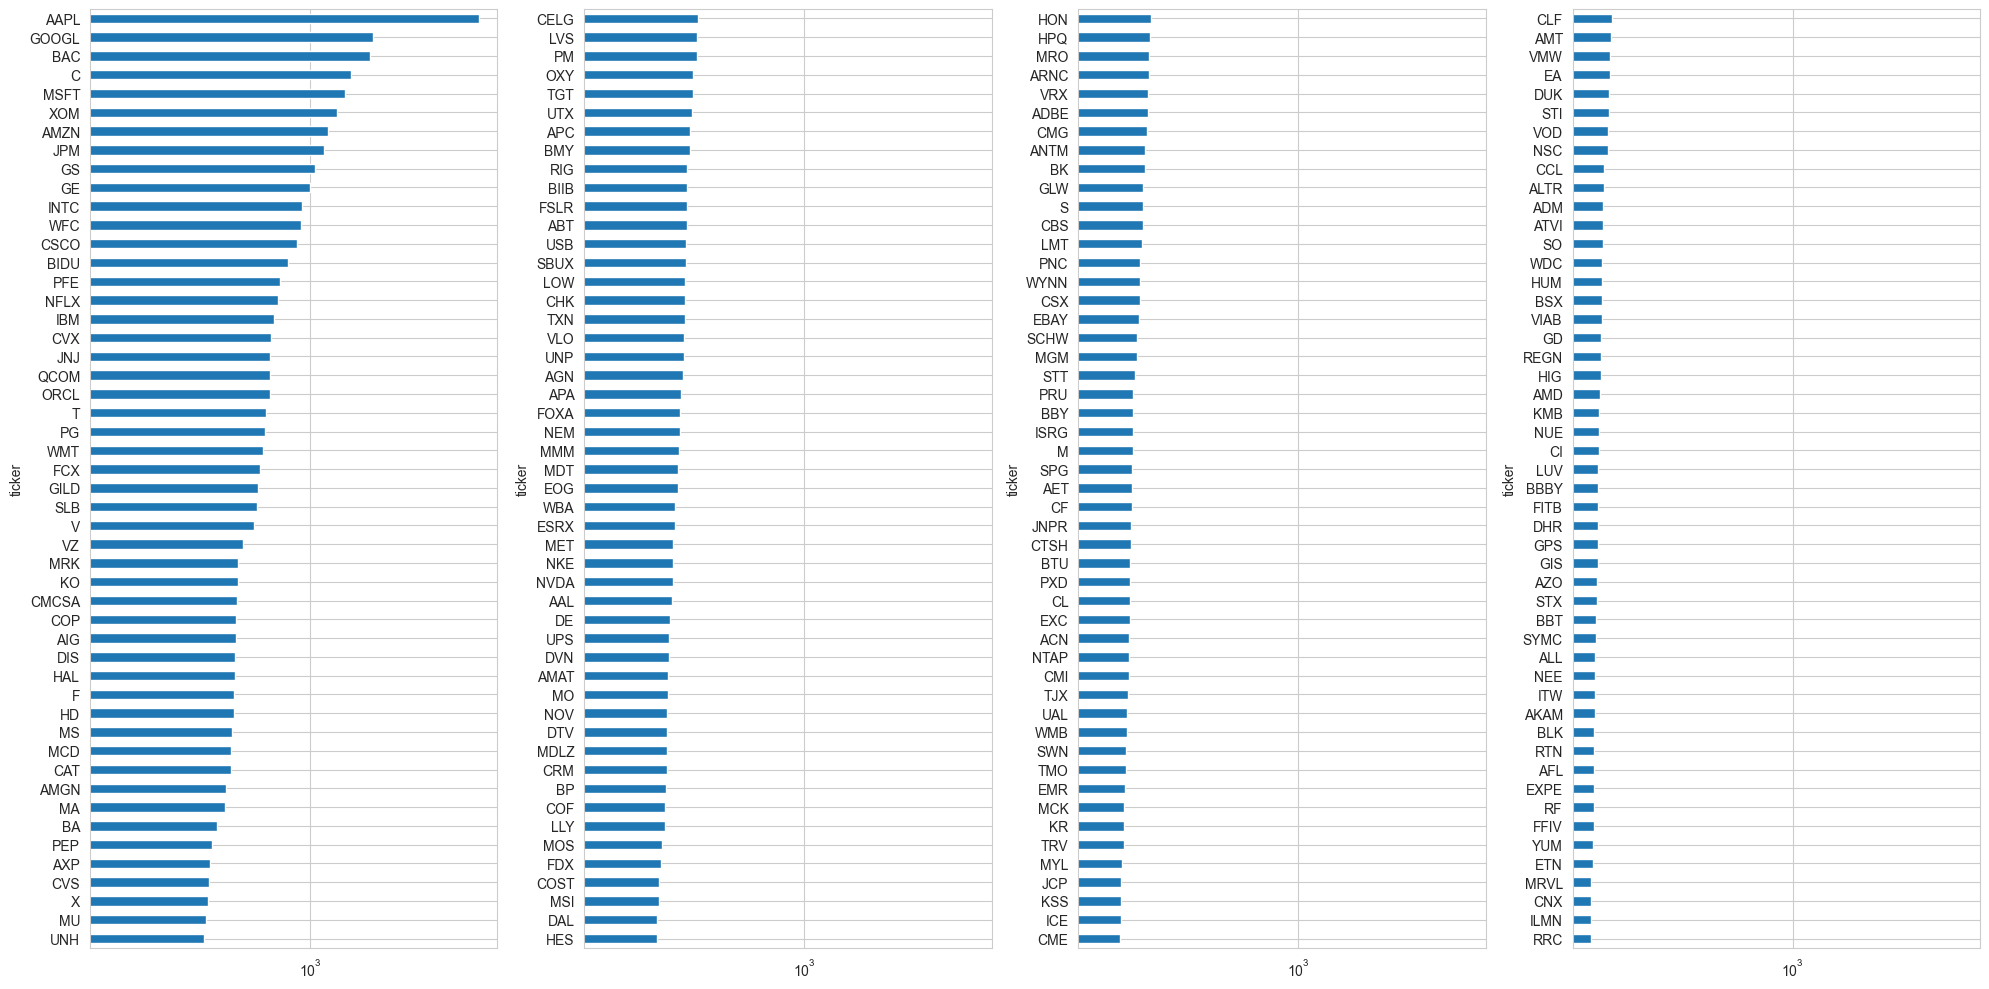

In [15]:
top200 = (data.close
          .mul(data.volume)
          .unstack('ticker')
          .dropna(thresh=8*252, axis=1)
          .mean()
          .div(1e6)
          .nlargest(200))
cutoffs = [0, 50, 100, 150, 200]
fig, axes = plt.subplots(ncols=4, figsize=(20, 10), sharex=True)
axes = axes.flatten()

for i, cutoff in enumerate(cutoffs[1:], 1):
    top200.iloc[cutoffs[i-1]:cutoffs[i]
                ].sort_values().plot.barh(logx=True, ax=axes[i-1])
fig.tight_layout()

In [16]:
to_drop = data.index.unique('ticker').difference(top500.index)

In [17]:
len(to_drop)

1899

In [18]:
data = data.drop(to_drop, level='ticker')

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1256095 entries, ('A', Timestamp('2007-01-03 00:00:00')) to ('ZION', Timestamp('2016-12-30 00:00:00'))
Data columns (total 7 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   open       1256095 non-null  float64
 1   high       1256095 non-null  float64
 2   low        1256095 non-null  float64
 3   close      1256095 non-null  float64
 4   volume     1256095 non-null  float64
 5   marketcap  1253855 non-null  float64
 6   sector     1256095 non-null  float64
dtypes: float64(7)
memory usage: 72.6+ MB


In [22]:
print(f"# Tickers: {len(data.index.unique('ticker')):,.0f} | # Dates: {len(data.index.unique('date')):,.0f}")

# Tickers: 500 | # Dates: 2,518


### Remove outlier observations based on daily returns

In [23]:
before = len(data)
data['ret'] = data.groupby('ticker').close.pct_change()
data = data[data.ret.between(-1, 1)].drop('ret', axis=1)
print(f'Dropped {before-len(data):,.0f}')

Dropped 502


In [24]:
tickers = data.index.unique('ticker')
print(f"# Tickers: {len(tickers):,.0f} | # Dates: {len(data.index.unique('date')):,.0f}")

# Tickers: 500 | # Dates: 2,517


### Sample price data for illustration

In [25]:
ticker = 'AAPL'
# alternative
# ticker = np.random.choice(tickers)
price_sample = data.loc[idx[ticker, :], :].reset_index('ticker', drop=True)

In [26]:
price_sample.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2517 entries, 2007-01-04 to 2016-12-30
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       2517 non-null   float64
 1   high       2517 non-null   float64
 2   low        2517 non-null   float64
 3   close      2517 non-null   float64
 4   volume     2517 non-null   float64
 5   marketcap  2517 non-null   float64
 6   sector     2517 non-null   float64
dtypes: float64(7)
memory usage: 157.3 KB


In [27]:
price_sample.to_hdf('data.h5', 'data/sample')

## Compute returns

Group data by ticker

In [28]:
by_ticker = data.groupby(level='ticker')

### Historical returns

In [29]:
T = [1, 2, 3, 4, 5, 10, 21, 42, 63, 126, 252]

In [30]:
for t in T:
    data[f'ret_{t:02}'] = by_ticker.close.pct_change(t)

### Forward returns

In [31]:
data['ret_fwd'] = by_ticker.ret_01.shift(-1)
data = data.dropna(subset=['ret_fwd'])

## Persist results

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1255093 entries, ('A', Timestamp('2007-01-04 00:00:00')) to ('ZION', Timestamp('2016-12-29 00:00:00'))
Data columns (total 19 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   open       1255093 non-null  float64
 1   high       1255093 non-null  float64
 2   low        1255093 non-null  float64
 3   close      1255093 non-null  float64
 4   volume     1255093 non-null  float64
 5   marketcap  1252855 non-null  float64
 6   sector     1255093 non-null  float64
 7   ret_01     1254593 non-null  float64
 8   ret_02     1254093 non-null  float64
 9   ret_03     1253593 non-null  float64
 10  ret_04     1253093 non-null  float64
 11  ret_05     1252593 non-null  float64
 12  ret_10     1250093 non-null  float64
 13  ret_21     1244593 non-null  float64
 14  ret_42     1234093 non-null  float64
 15  ret_63     1223593 non-null  float64
 16  ret_126    1192093 non-null  float64
 17  ret_252    

In [33]:
data.to_hdf('data.h5', 'data/top500')